> ###### *UNIVERSITY OF PISA* - *M.Sc. Computer Science (Artificial Intelligence)*
>
> **Continual Learning 2022/23**
>
> Irene Pisani \
> Matricola 560104 \
> i.pisani1@studenti.unipi.it \



# **An implementation of  Model Agnostic Meta Learning (MAML) for few-shot supervised image classification**


---



## **Project objectives**

---





1.   Provide an implementation  of MAML for few shot supervised learning  using Pytorch.

2.   Reproduce the  original experiments on the common few-shot images recognition benchmark: the Omniglot dataset.  Follow the original experimental protocol for image classification: fast learning of N-way classification with 1 or 5 shots and N equal to 5 or 20.

3.   Performance comparison between the original and the obtained ones.

4.   Analyze the impact of the number of inner SGD step during training and evaluation phases.

Steps 1. and 2. are addressed in notebook `MAML_Algorithm.ipynb`, while steps 3. and 4. are addressed in the current notebook `MAML_ExperimentalResults.ipynb` .



## **Utilities**

---



In [83]:
#@title Import useful tools and libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive




* `plot_learning_curve()`: show meta loss and meta accuracy behaviour among epoch for TR and VL set with the same configuration of hyperparamter used in the original paper.
* `show_ts_performance_table()`: show meta loss and meta accuracy achived on TS set with the same configuration of hyperparameter used in the original paper.
* `plot_innner_step_tr()`: show how TR and VL performance change when changing the number of SGD inner step used for training.
* `plot_innner_step_ts()`: show how TS performance change when changing the nummber of SGD inner step used for evaluation.



In [84]:
#@title Plot learning curves

def plot_learning_curves(path_tr, path_ts, features, labels, soa = None):

  # set plot config

  sns.set_theme()
  sns.set(rc={'figure.figsize':(6, 4)})

  # Read data for training and test performance over epochs

  cols_name_tr = [ "TR meta loss", "TR meta accuracy", "TR inner loss", "TR inner accuracy"]
  cols_name_ts = [ "VL meta loss", "VL meta accuracy", "VL inner loss", "VL inner accuracy"]

  history_tr = pd.read_csv(path_tr, index_col=0)
  history_ts = pd.read_csv(path_ts, index_col=0)

  history_tr.columns = cols_name_tr
  history_ts.columns = cols_name_ts

  history = pd.concat([history_tr, history_ts], axis=1)

  # Line plot of performance among epochs

  ax = sns.lineplot(data = history, x = history.index, y = features[0], label = str(features[0]))
  ax = sns.lineplot(data = history, x = history.index, y = features[1], label = str(features[1]))

  # visualize performance obtained by athors

  if soa != None: # only for accuracy values

    ax.axhline(soa, label = "TS MAML SoA", linestyle = "dashed", c = "indianred")
    ax.scatter(100, soa, marker='*', s=400,  c = "indianred", edgecolor = "white")

  # visualize last values of the sequences

  for l in ax.lines:
    y = l.get_ydata()
    ax.annotate(f'{y[-1]:.2f}', xy=(1, y[-1]), xycoords=('axes fraction', 'data'),
                     ha='left', va='center', color=l.get_color())

  # add labels
  ax.set(xlabel = labels[1] , ylabel = labels[0])


  plt.legend()
  plt.show()

In [85]:
#@title Show TS performance table
def show_ts_performance_table(path, inner_step, soa):

  # Read data for training and test performance
  cols_name_ts = [ "TS inner step", "TS meta loss", "TS meta accuracy", "TS inner loss", "TS inner accuracy"]
  ts = pd.read_csv(path, index_col=0)
  ts.columns = cols_name_ts

  # filter by inner step values, keep only deafult inner step values
  ts = ts[ts["TS inner step"] == inner_step ]
  ts = ts.mean().to_frame().T

  # add row for original performance
  soa_row = {"TS inner step": inner_step,
              "TS meta loss": None,
              "TS meta accuracy": soa,
              "TS inner loss": None,
              "TS inner accuracy": None}

  #  add the new row for original results
  ts = ts.append(soa_row, ignore_index=True)

  ts.index = ['our', 'original']
  return ts




In [86]:
#@title Plot impact of SGD inner step on TR performance

def plot_inner_step_tr (path1_tr, path3_tr, path5_tr, path1_vl, path3_vl, path5_vl, feature, labels):

  def get_df(path, cols ):

    # read file csv
    innerstep = pd.read_csv(path, index_col=0)
    innerstep.columns = cols

    return innerstep

  # set plot config
  sns.set_theme()
  sns.set(rc={'figure.figsize':(6, 4)})

  # Read data for training and test performance
  cols_name_tr = [ "TR meta loss", "TR meta accuracy", "TR inner loss", "TR inner accuracy"]
  cols_name_vl = [ "VL meta loss", "VL meta accuracy", "VL inner loss", "VL inner accuracy"]

  tr_1innerstep = get_df(path1_tr, cols_name_tr)
  tr_3innerstep = get_df(path3_tr, cols_name_tr)
  tr_5innerstep = get_df(path5_tr, cols_name_tr)

  vl_1innerstep = get_df(path1_vl, cols_name_vl)
  vl_3innerstep = get_df(path3_vl, cols_name_vl)
  vl_5innerstep = get_df(path5_vl, cols_name_vl)

  # Line plot of performance among epochs

  ax = sns.lineplot(data = tr_1innerstep, x = tr_1innerstep.index, y = feature[0], label = 'TR - 1 inner SGD step', color = "#4c72b0")
  ax = sns.lineplot(data = tr_3innerstep, x = tr_1innerstep.index, y = feature[0], label = 'TR - 3 inner SGD step', color = "#dd8452")
  ax = sns.lineplot(data = tr_5innerstep, x = tr_1innerstep.index, y = feature[0], label = 'TR - 5 inner SGD step', color = "#55a868", )
  ax = sns.lineplot(data = vl_1innerstep, x = vl_1innerstep.index, y = feature[1], label = 'VL - 1 inner SGD step', color = "#4c72b0", linestyle = "dotted")
  ax = sns.lineplot(data = vl_3innerstep, x = vl_1innerstep.index, y = feature[1], label = 'VL - 3 inner SGD step', color = "#dd8452", linestyle = "dotted")
  ax = sns.lineplot(data = vl_5innerstep, x = vl_1innerstep.index, y = feature[1], label = 'VL - 5 inner SGD step', color = "#55a868", linestyle = "dotted")

  # add labels
  ax.set(xlabel = 'Epochs', ylabel = labels)

  if labels == "Loss":
    plt.yscale('log')


  plt.legend()
  plt.show()

In [87]:
#@title Plot impact of SGD inner step  on TS performance

def plot_inner_step_ts (path1, path3, path5):

  def get_df(path, tr_inner_step):

    # read file
    ts_innerstep = pd.read_csv(path, index_col=0)
    ts_innerstep.columns = cols_name_ts

    # gruoup by TS inner step and get mean values
    ts_innerstep["TR inner step"] = tr_inner_step
    ts_innerstep = ts_innerstep.groupby('TS inner step', as_index = False).mean()

    return ts_innerstep

  # Read data for training and test performance
  cols_name_ts = [ "TS inner step", "TS meta loss", "TS meta accuracy", "TS inner loss", "TS inner accuracy"]

  ts_5 = get_df(path5, 5)
  ts_3 = get_df(path3, 3)
  ts_1 = get_df(path1, 1)

  # get final dataframe
  ts = pd.concat([ts_1, ts_3, ts_5], axis=0)
  ts.set_index(['TR inner step', 'TS inner step'], inplace = True)

  return ts

## **Experimental results**

---



The following table show a comparison between the TS accuracy achieved in this project and TS accuracy achieved by the author of the original paper.

NB. All hyperparameters are the same used in the original works expect for the number of epochs. Image augmentations were not applied.

| MAML mplementation | 5 way 1 shot | 5 way 5 shot | 20 way 1 shot | 20 way 5 shot |
| --- | --- | --- | --- |--- |
| My MAML in Pytorch | 93.99 | 98.01 | 80.92 | 92.90 |
| Original MAML | 98.70 | 99.9 | 95.8  | 98.9 |

A more detailed analysis of the results is given in the following sections.

### **5-way 1-shot image classification**



In [88]:
# classification problem: 5-way 1-shot
n_way = 5
k_shot = 1

# path to files csv
options = SimpleNamespace(

    # TR performance
    innerstep1_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_1innerstep.csv',
    innerstep3_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_3innerstep.csv',
    innerstep5_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_5innerstep.csv',

    # VL performance
    innerstep1_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_1innerstep.csv',
    innerstep3_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_3innerstep.csv',
    innerstep5_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_5innerstep.csv',

    # TS performance
    innerstep1_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_1-[1, 3, 5, 10]innerstep.csv',
    innerstep3_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_3-[1, 3, 5, 10]innerstep.csv',
    innerstep5_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_5-[1, 3, 5, 10]innerstep.csv',
)

Deafult inner step for comparison with original work:
- training SGD inner step: 1
- evaluation SGD inner step: 3

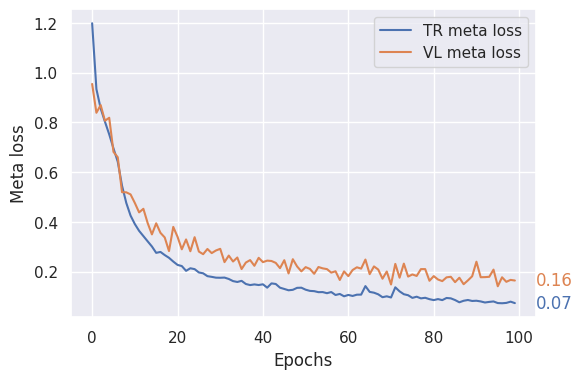

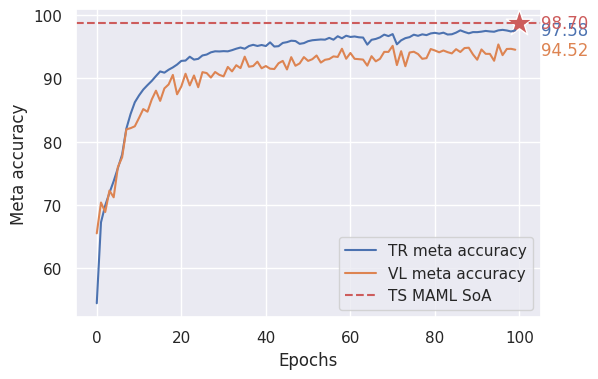

In [89]:
# Plot learning curve for TR and VL
plot_learning_curves(options.innerstep1_tr, options.innerstep1_vl, features = ["TR meta loss", "VL meta loss"], labels = ["Meta loss", "Epochs"])
plot_learning_curves(options.innerstep1_tr, options.innerstep1_vl, features = ["TR meta accuracy", "VL meta accuracy"], labels = ["Meta accuracy", "Epochs"], soa = 98.7)

In [90]:
# Show TS performance
show_ts_performance_table(options.innerstep1_ts, inner_step = 3, soa = 98.7)

<ipython-input-85-94385176a41a>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts = ts.append(soa_row, ignore_index=True)


,TS inner step,TS meta loss,TS meta accuracy,TS inner loss,TS inner accuracy
our,3.0,0.178654,93.995444,0.002282,99.980769
original,3.0,NaN,98.700000,NaN,NaN


Impact of changing the number of SGD inner step used during training.

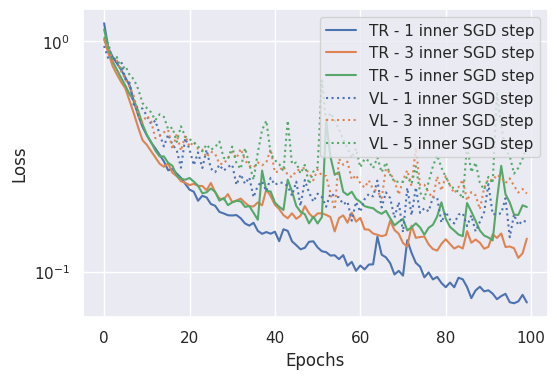

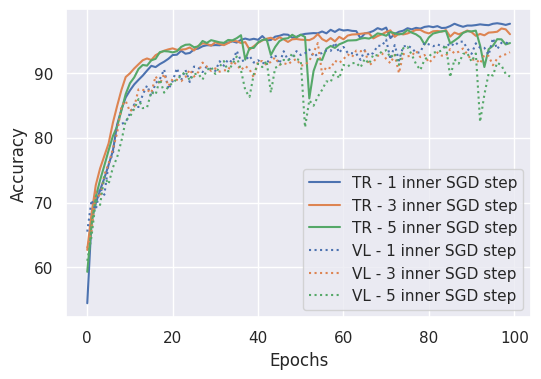

In [91]:
plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta loss", "VL meta loss"], labels = "Loss")

plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta accuracy", "VL meta accuracy"], labels = "Accuracy")

Impact of changing the number of SGD inner step used for evaluation.

Performance on TS set.

In [92]:
plot_inner_step_ts (options.innerstep1_ts, options.innerstep3_ts, options.innerstep5_ts)

TS meta loss  TS meta accuracy  TS inner loss  \
TR inner step TS inner step                                                  
1.0           1                  0.184045         93.804401       1.637187   
              3                  0.178654         93.995444       0.002282   
              5                  0.175011         94.135625       0.001084   
              10                 0.172047         94.239370       0.000615   
3.0           1                  0.298742         90.052883       1.638682   
              3                  0.240660         92.635120       0.013939   
              5                  0.235891         92.640179       0.005987   
              10                 0.223731         92.903084       0.003403   
5.0           1                  0.341510         88.944836       1.635832   
              3                  0.260244         92.594128       0.021283   
              5                  0.240496         92.954198       0.008701   
              10                 0.226377         93.267964       0.004581   

                             TS inner accuracy  
TR inner step TS inner step                     
1.0           1                      20.269231  
              3                      99.980769  
              5                      99.995192  
              10                    100.000000  
3.0           1                      19.951923  
              3                      99.860576  
              5                      99.995192  
              10                    100.000000  
5.0           1                      20.360577  
              3                      99.687499  
              5                      99.985577  
              10                    100.000000

### **5-way 5-shot image classification**



In [93]:
# classification problem: 5-way 1-shot
n_way = 5
k_shot = 5

# path to files csv
options = SimpleNamespace(

    # TR performance
    innerstep1_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_1innerstep.csv',
    innerstep3_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_3innerstep.csv',
    innerstep5_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_5innerstep.csv',

    # VL performance
    innerstep1_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_1innerstep.csv',
    innerstep3_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_3innerstep.csv',
    innerstep5_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_5innerstep.csv',

    # TS performance
    innerstep1_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_1-[1, 3, 5, 10]innerstep.csv',
    innerstep3_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_3-[1, 3, 5, 10]innerstep.csv',
    innerstep5_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_5-[1, 3, 5, 10]innerstep.csv',
)

Deafult inner step for comparison with original work:
- training SGD inner step: 1
- evaluation SGD inner step: 3

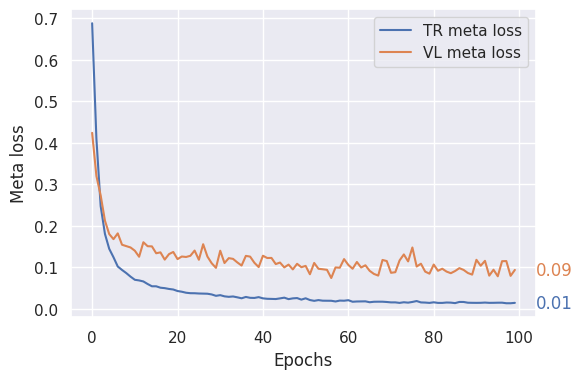

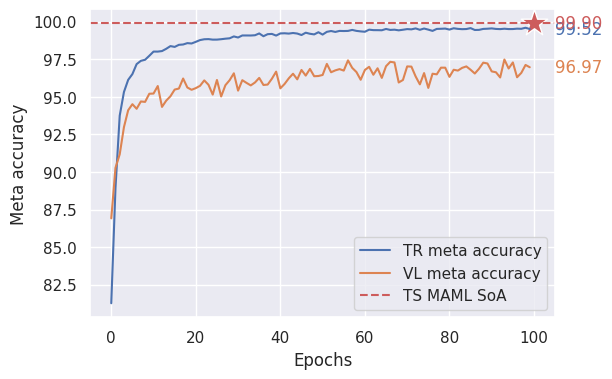

In [94]:
# Plot learning curve for TR and VL
plot_learning_curves(options.innerstep1_tr, options.innerstep1_vl, features = ["TR meta loss", "VL meta loss"], labels = ["Meta loss", "Epochs"])
plot_learning_curves(options.innerstep1_tr, options.innerstep1_vl, features = ["TR meta accuracy", "VL meta accuracy"], labels = ["Meta accuracy", "Epochs"], soa = 99.9)

In [95]:
# Show TS performance
show_ts_performance_table(options.innerstep1_ts, inner_step = 3, soa = 99.9)

<ipython-input-85-94385176a41a>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts = ts.append(soa_row, ignore_index=True)


,TS inner step,TS meta loss,TS meta accuracy,TS inner loss,TS inner accuracy
our,3.0,0.060629,98.019226,0.001179,99.996154
original,3.0,NaN,99.900000,NaN,NaN


Impact of changing the number of SGD inner step used during training.

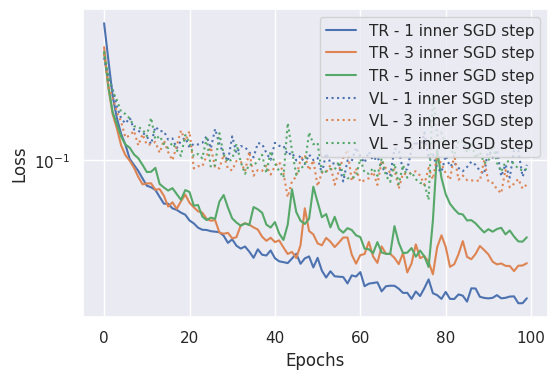

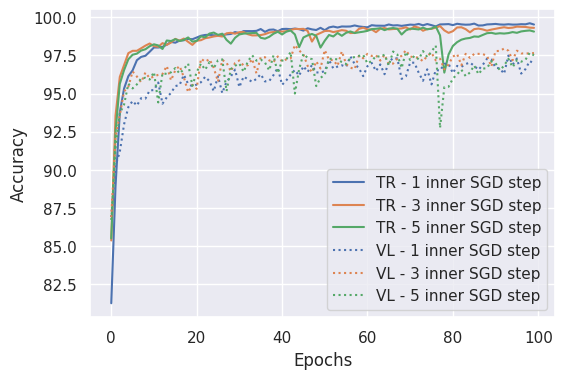

In [96]:
plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta loss", "VL meta loss"], labels = "Loss")

plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta accuracy", "VL meta accuracy"], labels = "Accuracy")

Impact of changing the number of SGD inner step used for evaluation.

Performance on TS set.

In [97]:
plot_inner_step_ts (options.innerstep1_ts, options.innerstep3_ts, options.innerstep5_ts)

TS meta loss  TS meta accuracy  TS inner loss  \
TR inner step TS inner step                                                  
1.0           1                  0.063147         97.927240       1.711088   
              3                  0.060629         98.019226       0.001179   
              5                  0.060067         98.011535       0.000809   
              10                 0.059151         98.082688       0.000564   
3.0           1                  0.073009         97.548073       1.720990   
              3                  0.068726         97.766021       0.002971   
              5                  0.068079         97.820189       0.001995   
              10                 0.068233         97.781087       0.001113   
5.0           1                  0.071726         97.607048       1.743577   
              3                  0.067598         97.897111       0.004739   
              5                  0.061792         98.035253       0.002514   
              10                 0.058437         98.146150       0.001366   

                             TS inner accuracy  
TR inner step TS inner step                     
1.0           1                      19.932692  
              3                      99.996154  
              5                     100.000000  
              10                    100.000000  
3.0           1                      20.301923  
              3                      99.972116  
              5                      99.987500  
              10                    100.000000  
5.0           1                      19.929807  
              3                      99.929807  
              5                      99.987500  
              10                    100.000000

### **20-way 1-shot image classification**



In [98]:
# classification problem: 5-way 1-shot
n_way = 20
k_shot = 1

# path to files csv
options = SimpleNamespace(

    # TR performance
    innerstep5_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_5innerstep.csv',
    innerstep3_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_3innerstep.csv',
    innerstep1_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_1innerstep.csv',

    # VL performance
    innerstep5_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_5innerstep.csv',
    innerstep3_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_3innerstep.csv',
    innerstep1_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_1innerstep.csv',

    # TS performance
    innerstep5_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_5-[1, 3, 5, 10]innerstep.csv',
    innerstep3_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_3-[1, 3, 5, 10]innerstep.csv',
    innerstep1_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_1-[1, 3, 5, 10]innerstep.csv',
)

Deafult inner step for comparison with original work:
- training SGD inner step: 5
- evaluation SGD inner step: 5

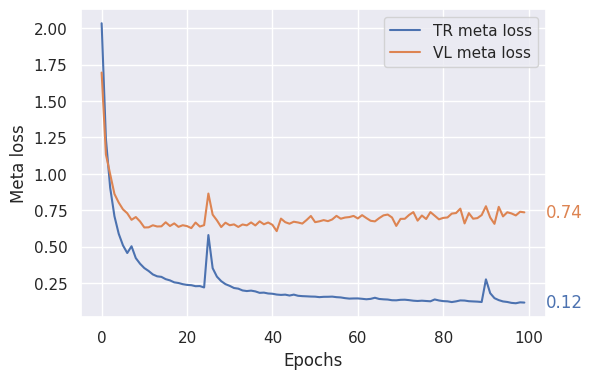

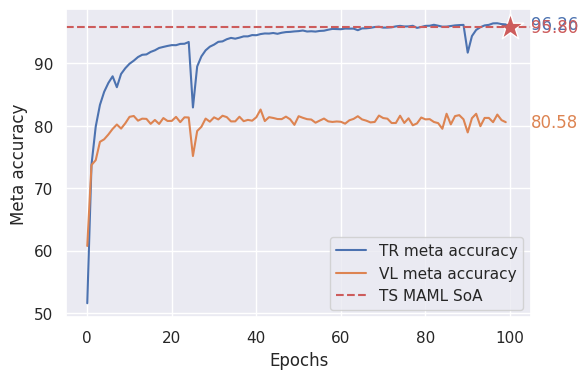

In [99]:
# Plot learning curve for TR and VL
plot_learning_curves(options.innerstep5_tr, options.innerstep5_vl, features = ["TR meta loss", "VL meta loss"], labels = ["Meta loss", "Epochs"])
plot_learning_curves(options.innerstep5_tr, options.innerstep5_vl, features = ["TR meta accuracy", "VL meta accuracy"], labels = ["Meta accuracy", "Epochs"], soa = 95.8)

In [100]:
# Show TS performance
show_ts_performance_table(options.innerstep5_ts, inner_step = 5, soa = 95.8)

<ipython-input-85-94385176a41a>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts = ts.append(soa_row, ignore_index=True)


,TS inner step,TS meta loss,TS meta accuracy,TS inner loss,TS inner accuracy
our,5.0,0.657148,80.921684,0.001105,99.993991
original,5.0,NaN,95.800000,NaN,NaN


Impact of changing the numbeber of SGD inner step used during training.

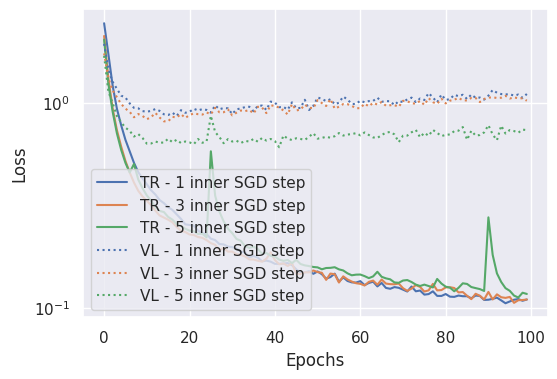

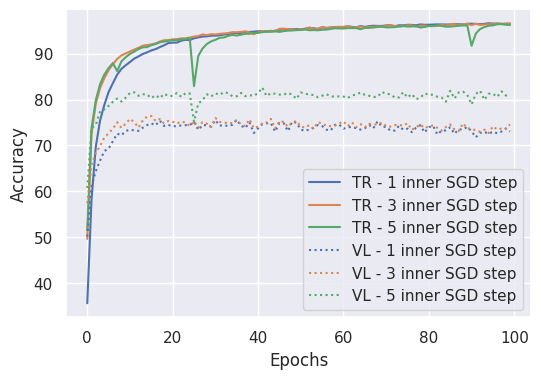

In [101]:
plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta loss", "VL meta loss"], labels = "Loss")

plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta accuracy", "VL meta accuracy"], labels = "Accuracy")

Impact of changing the number of SGD inner step used for evaluation.

Performance on TS set.

In [102]:
plot_inner_step_ts (options.innerstep1_ts, options.innerstep3_ts, options.innerstep5_ts)

TS meta loss  TS meta accuracy  TS inner loss  \
TR inner step TS inner step                                                  
1.0           1                  0.678615         80.062246       3.158834   
              3                  0.670816         80.325024       0.002881   
              5                  0.664045         80.497279       0.002231   
              10                 0.659653         80.662891       0.001569   
3.0           1                  0.673632         80.137461       3.128551   
              3                  0.655333         80.760690       0.004926   
              5                  0.646723         80.987536       0.003519   
              10                 0.640102         81.241206       0.002311   
5.0           1                  0.669139         80.584765       3.162823   
              3                  0.664041         80.704073       0.001503   
              5                  0.657148         80.921684       0.001105   
              10                 0.661176         80.787196       0.000694   

                             TS inner accuracy  
TR inner step TS inner step                     
1.0           1                       4.943510  
              3                      99.998798  
              5                     100.000000  
              10                    100.000000  
3.0           1                       4.921875  
              3                      99.995193  
              5                     100.000000  
              10                    100.000000  
5.0           1                       4.906250  
              3                      99.992790  
              5                      99.993991  
              10                     99.998798

### **20-way 5-shot image classification**



In [103]:
# classification problem: 5-way 1-shot
n_way = 20
k_shot = 5

# path to files csv
options = SimpleNamespace(

    # TR performance
    innerstep5_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_5innerstep.csv',
    innerstep3_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_3innerstep.csv',
    innerstep1_tr = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TR_1innerstep.csv',

    # VL performance
    innerstep5_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_5innerstep.csv',
    innerstep3_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_3innerstep.csv',
    innerstep1_vl = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/VL_1innerstep.csv',

    # TS performance
    innerstep5_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_5-[1, 3, 5, 10]innerstep.csv',
    innerstep3_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_3-[1, 3, 5, 10]innerstep.csv',
    innerstep1_ts = f'/content/drive/MyDrive/MAML/{n_way}way/{k_shot}shot/TS_1-[1, 3, 5, 10]innerstep.csv',
)

Deafult inner step for comparison with original work:
- training SGD inner step: 5
- evaluation SGD inner step: 5

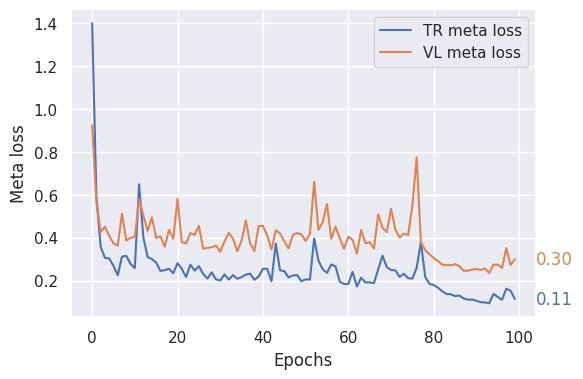

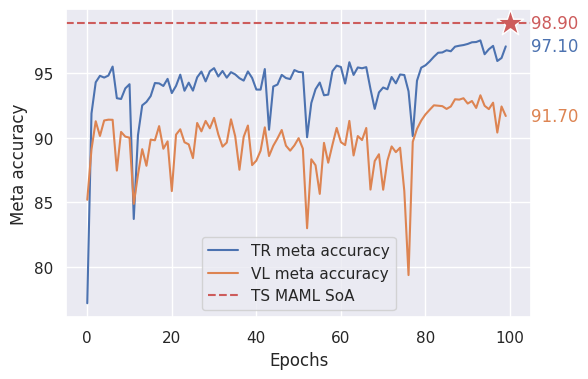

In [104]:
# Plot learning curve for TR and VL
plot_learning_curves(options.innerstep5_tr, options.innerstep5_vl, features = ["TR meta loss", "VL meta loss"], labels = ["Meta loss", "Epochs"])
plot_learning_curves(options.innerstep5_tr, options.innerstep5_vl, features = ["TR meta accuracy", "VL meta accuracy"], labels = ["Meta accuracy", "Epochs"], soa = 98.9)

In [105]:
# Show TS performance
show_ts_performance_table(options.innerstep5_ts, inner_step = 5, soa = 98.9 )

<ipython-input-85-94385176a41a>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts = ts.append(soa_row, ignore_index=True)


,TS inner step,TS meta loss,TS meta accuracy,TS inner loss,TS inner accuracy
our,5.0,0.246181,92.900717,0.017641,99.944952
original,5.0,NaN,98.900000,NaN,NaN


Impact of changing the number of SGD inner step used during training.

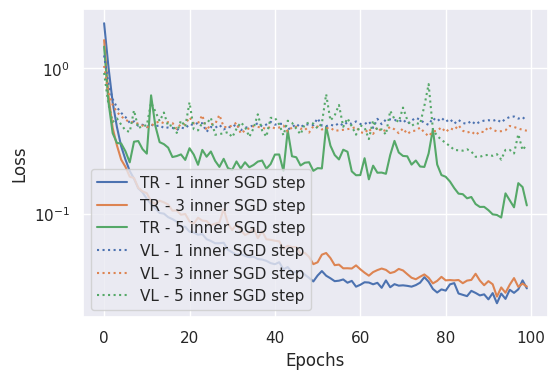

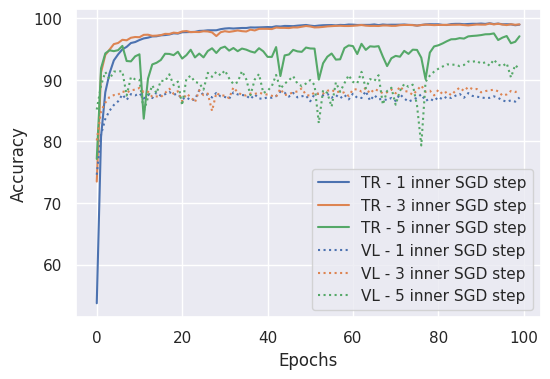

In [106]:
plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta loss", "VL meta loss"], labels = "Loss")

plot_inner_step_tr (options.innerstep1_tr,
                    options.innerstep3_tr,
                    options.innerstep5_tr,
                    options.innerstep1_vl,
                    options.innerstep3_vl,
                    options.innerstep5_vl,
                    feature = ["TR meta accuracy", "VL meta accuracy"], labels = "Accuracy")

Impact of changing the number of SGD inner step used for evaluation.

Performance on TS set.

In [107]:
plot_inner_step_ts (options.innerstep1_ts, options.innerstep3_ts, options.innerstep5_ts)

TS meta loss  TS meta accuracy  TS inner loss  \
TR inner step TS inner step                                                  
1.0           1                  0.304097         90.638939       3.570570   
              3                  0.274585         91.640863       0.007690   
              5                  0.265397         91.937737       0.004632   
              10                 0.262469         92.052079       0.002820   
3.0           1                  0.936726         81.170189       3.351016   
              3                  0.238914         92.763779       0.012968   
              5                  0.230867         93.020831       0.004502   
              10                 0.230742         93.009531       0.001758   
5.0           1                  0.380145         88.146872       3.626291   
              3                  0.262001         92.490221       0.036254   
              5                  0.246181         92.900717       0.017641   
              10                 0.230092         93.326519       0.009099   

                             TS inner accuracy  
TR inner step TS inner step                     
1.0           1                       4.954567  
              3                      99.961779  
              5                      99.994471  
              10                    100.000000  
3.0           1                       5.020192  
              3                      99.751683  
              5                      99.962260  
              10                    100.000000  
5.0           1                       5.055529  
              3                      99.661779  
              5                      99.944952  
              10                     99.997356

## **Results analysis**


---



### **5 way few shot image classification**

#### **General consideration**.

The experiments carried out with 1-shot showed a 4,71% accuracy gap on the TS set between the obtained performance and the original ones, while experiments with 5-shot showed a 1,89% accuracy gap (quite small).

This result was expected for the following reasons:
- 5-shot classification problem is simpler than 1-shot: more samples of each task are given to the model during training fast adapatation, thus allowing the model to extract more relevant information about the task. Consequently, it was predictable to expect better performance with 5-shot classification than with 1-shot classification.
- a gap between the performance obtained in these experiments and the original performance was expected since the models were trained on fewer epochs.

Some useful solutions to achieve performance equal to the original ones are listed below:
- Looking at the learning curve, it can be seen that these are quite stable; in particular, the VL loss and TR loss are still decreasing after 100 epochs. This means that to achieve better performance, the number of epochs must be increased.

#### **Impact of increasing the number of SGD inner step during training.**

For 5 way classification, the optimal (and deafault) number of SGD inner step for training is 1. This value helps the model to learn, during the inner loop on a single task, adapted parameters θ' capable of not affecting the meta update, i.e., not pushing the model parameters θ toward values that are too task-specific but encouraging the learning of general-purpose internal representations applicable to a variety of tasks.

When increasing the number of inner SGD step from 1 to 3 or 5, the adapated parameter θ' computed in the inner loop are adapting too much to the support set, and results in a larger loss on the query set. Larger loss on the query set cause bigger change in meta-update for θ parameter, thus making the whole training phase more unstable.

The more the number of inner step are used the more the training will be unstable. However, results show that for 3 and 5 inner step it's possible to achieve performance similar to that obtained with only 1 inner step.

#### **Impact of the number of SGD step during evaluation.**

When new task from TS set arrive, the model is adapted to k sample with 3 inner step by deafult.

Experiments show that only 1 innerstep is not enough to achive significative performance. 3 inner step seems the minimum number of inner step able to cause a change in θ that results in large improvements on the loss of any new task, when altered in the direction of the gradient of that loss.

Anyway, it' intersting to observe that the models continue to improve with additional gradient steps (i.e, using 5 or 10 grandient step for evaluation), despite being trained for one gradient step. Authors themeselves testify this improvement: they explain that this is due to the fact that MAML optimizes the parameters such that they lie in a region that is amenable to fast adaptation and is sensitive to loss functions from the distribution of tasks p(T) rather than overfitting to parameters θ that only improve after one step.


#### **Best performance.**

We have to mention that the best performance obtained for 5-way 1-shot classification come from a model trained with 1 inner step at training time and 10 inner step at evalutaion time: 94.23 of TS accuracy is achieved against the 93.99 TS accuracy achieved with deafult inner step values.

The best performance obtained for 5-way 5-shot classification come from a model trained with 5 inner step at training time and 10 inner step at evalutaion time: 98.14 of TS accuracy is achieved against the 98.01 TS accuracy achieved with deafult inner step values.

Note that when the number of training and evaluation gradient step are increased both training and inference time get longer.




### **20 way few shot image classification**


#### **General consideration**.

The experiments carried out with 1-shot showed a 14,8% accuracy gap (quite large) on the TS set between the obtained performance and the original ones, while experiments with 5-shot showed a 6% accuracy gap.

This result was expected for the following reasons:
- Again, 5-shot classification problem is simpler than 1-shot.
- Also in this case, a gap between the performance obtained in these experiments and the original performance was expected since the models were trained on fewer epochs.
- More in general, lower performance with 20-way classification wrt 5-way classification were expected: the whole problem is more complex and  most of the popolar implementation of MAML achieve lower performance under the 20-way settings.

Some useful solutions to achieve performance equal to the original ones are given below.

Of curse, also in this case to achieve better performance, the number of epochs must be increased.

However, for the 20 way 5-shot classification we can observe very unstable learning curve during training both on TR set and VL set. This instability does not guarantee that the VL loss and TR loss will be still decreasing with further epochs.

For the way 20 way 1-shot classification we are clearly in a overfitting situation: TR loss is decrasing among epochs while VL loss is increasing.

All these observations lead to the conclusion that increasing the number of epochs is not sufficient to achieve the same performance as reported in the original paper.

First of all, we have to handle overfitting situation. In the original paper all images in the Omniglot dataset where augmentated with rotations of multiple of 90 degrees. In this project augmentationa were not applied but future works should address the integration of such technique. In fact, as stated by Santoro et al in *Meta-Learning with Memory-Augmented Neural Networks*, the role of image augmentations with rotation is to reduce the risk of overfitting.
Therefore, I think that the performance on 1-shot 20-way was particularly compromised by the absence of image augmentations. I expect that that this performance can significantly improve through the reintroduction of this augmentation technique, always accompanied by more training epochs.

It's worth noting that also other experimental protocols (5-way, 1-shot, 20-way 5-shot etc.) could significantly benefit from the introduction of augmentations.

On the other side we have to deal with relevant training instability Although the original paper does not mention this problem, it has been proven and well discussed by Antoniou et el in *How to train your MAML* (2019):

"optimizing the outer loop involved backpropagating derivatives through an unfolded inner loop consisting of the same network multiple times. This alone could be cause for gradient issues. However, the gradient issues are further compounded by the model architecture, which is a standard 4-layer convolutional network without skip-connections. The lack of any skip-connections means that every gradient must be passed through each convolutional layer many times; effectively the gradients will be multiplied by the same sets of parameters multiple times. After multiple back-propagation passes, the large depth structure of the unfolded network and lack of skip connections can cause gradient explosions and diminishing gradient problems respectively.

A popolar strategy to mitigate this MAML issues is to introduce gradient clipping technique.


#### **Impact of decreasing the number of SGD inner step during training.**

For 20 way classification, the optimal (and deafault) number of SGD inner step used for training is 5.

In this project, no models were trained for 20-way classification with more than 5 inner SGD steps. This is due to computational and time constraints imposed by colab's GPU.
However I tried to analyze what happen when the number of SGD inner step used for training is decreased.

When decreasing the number of inner SGD step from 1 to 3 or 5 when can observe more stable TR curves, at the expense of a greater gap between performance on the TR and VL set. Looking at the VL losses, it's evident that using fewer inner steps at training time leads to a lack of generalization capabilities on new tasks.

#### **Impact of the number of SGD step during evaluation.**

Also in this case, experiments show that using only 1 innerstep is not enough to achieve significative TS performance. Although the optimum value (used by the authors) of inner step for evaluation is 5, using 3 inner steps already allows high performance that deviates very little from the ones obtained with 5 inner steps.

Again, as the number of inner steps used for evaluation increase TS performance increase as well.

#### **Best performance.**

The best performance obtained for 20-way 1-shot classification come from a model trained with 3 inner step at training time and 10 inner step at evalutaion time: 81.24 of TS accuracy is achieved against the 80.92 TS accuracy achieved with deafult inner step values.

The best performance obtained for 20-way 5-shot classification come from a model trained with 5 inner step at training time and 10 inner step at evalutaion time: 93.32 of TS accuracy is achieved against the 92.90 TS accuracy achieved with deafult inner step values.

## **Conclusion and future work**

---




MAML is a powerful optimization-based meta-learning algorithm that is model-agnostic (compatible with any model trained with gradient descent),applicable to a variety of different learning problems (such as classification, regression, and reinforcement learning). It leads to state of art result on few-shot image classification benchmarks since the  parameters of the model are explicitly trained such that a small amount of training data from a new task will produce good generalization performance on that task.

Anyway, MAML is sensitive to NN  architectures, leads to training instability, requires arduous hyperparameter searches and it’s computationally expensive at both training and inference times.  

In order to stabilize the system and to improve the generalization performance, convergence speed and computational overhead it's possible to integrate the algorithm with some refinements suggested by  Antoniou et al. in *How to train your MAML*. Some posssibile future works based on the mentioned paper are listed below.

A simple way to achieve more training stability and to improve gradient propagation is minimizing the query set loss computed by the base-learner after every step towards a support set task (instead of minimizing the query set loss computed by the base-learner after it has completed all of its inner-loop updates towards a support set task).

In order to produce higher generalization performance and allievate overfitting, it's suggested to use a cosine annealing-scheduling of the meta-optimizer learning rate as well as a method for learning per-layer per-innerstep the inner learning rate.

At the end, using running batch statistics collected in a per-step regime during batch normalization should be determinant for speed up optimization convergence and improve generalization and stability.

## **References**

---





*  [Chelsea Finn, Pieter Abbeel, and Sergey Levine. *Model-agnostic meta-learning for fast adaptation of deep networks.* (2017).](https://arxiv.org/pdf/1703.03400.pdf)
*   [Antreas Antoniou, Amos Storkey, Harrison Edwards. *How to train your MAML.* (2019).](https://arxiv.org/pdf/1810.09502.pdf)
*   [Bronskill, Gordon, Requeima,  Nowozin, Turner. *TaskNorm: Rethinking Batch Normalization for Meta-Learning*. (2020).](https://arxiv.org/pdf/2003.03284.pdf)
*[Adam Santoro, Sergey Bartunov, Matthew Botvinick, Daan Wierstra,
Timothy Lillicrap. *Meta-Learning with Memory-Augmented Neural Networks.* (2016).](https://proceedings.mlr.press/v48/santoro16.pdf)
*   https://github.com/cbfinn/maml
*   https://github.com/dragen1860/MAML-Pytorch
*   https://pytorch.org/docs/stable/func.html
